In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
from yt.analysis_modules.ppv_cube.api import PPVCube
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=32

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
<ipython-input-1-0702b115969a>:25: VisibleDeprecationWarning: Development of the PPVCube module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://github.com/yt-project/yt_astro_analysis for further information.
  from yt.analysis_modules.ppv_cube.api import PPVCube


In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds

In [6]:
import cv2

In [3]:
train_ds = ds.MNIST(root='./data_cache',train=True,download=True, transform=None)
test_ds = ds.MNIST(root='./data_cache',train=False,download=True, transform=None)

In [4]:
temp = train_ds.data.detach().cpu().numpy()

In [5]:
def mnist_pad(im, theta=0):
    impad = np.zeros((64,64))
    impad[18:46,18:46] = im
    imbig = np.array(Image.fromarray(impad).resize((128,128)))
    if theta != 0.0:
        imrot = rotate_image(imbig, theta)
    else:
        imrot = imbig
    return imrot

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result_real = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LANCZOS4)
    return result_real

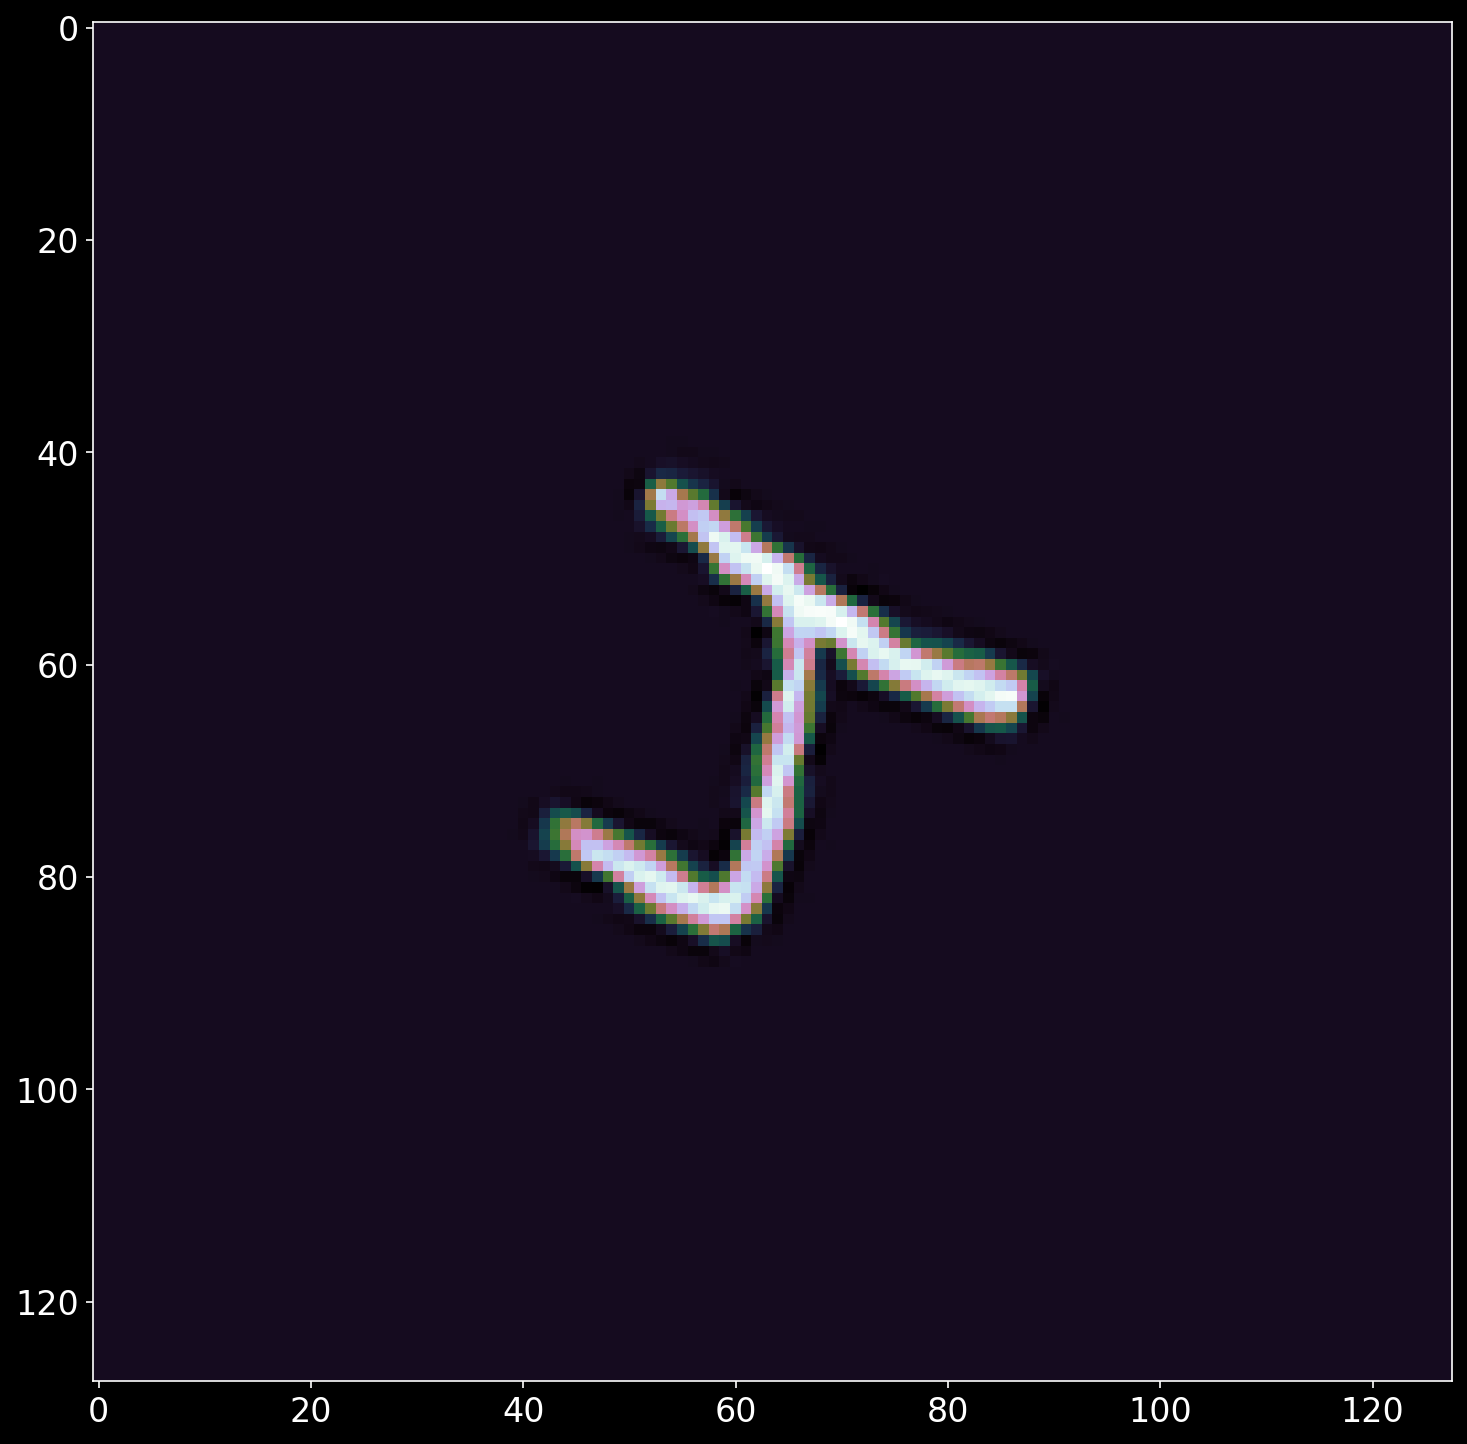

In [7]:
fig = plt.figure(figsize=(12,12),dpi=150)
ax = fig.add_subplot(1,1,1)    
ax.imshow(mnist_pad(temp[2,:,:],theta=68.75), cmap = 'cubehelix')

In [8]:
# PreCalc the WST Network
J = 7
L = 8
m = 2
scattering = Scattering2D(J=J, shape=(128,128), L=L, max_order=m)

In [9]:
import multiprocessing
from torch.multiprocessing import Pool
for p in multiprocessing.active_children():
    p.terminate()

In [48]:
lst = []
train_temp = train_ds.data.detach().cpu().numpy()
for i in range(60000):
    lst.append(train_temp[i,:,:])

lst_test = []
test_temp = test_ds.data.detach().cpu().numpy()
for i in range(10000):
    lst_test.append(test_temp[i,:,:])

In [43]:
def mnist_WST(theta, x):
    # = params
    print(theta)
    image    = mnist_pad(x, theta=theta)
    Nx, Ny = image.shape
    S0 = np.mean(image)
    norm_im = image - S0
    S1   = np.sum(np.square(norm_im))/(Nx*Ny)
    norm_im /= np.sqrt(Nx*Ny*S1)
    WST = WST_torch(norm_im,scattering).flatten()
    return np.append([S0,S1],WST)

In [12]:
def WST_torch(src_img,scattering):
    src_img = src_img.astype(np.float32)
    src_img_tensor = torch.from_numpy(src_img).to(device).contiguous()
    scattering_coefficients = scattering(src_img_tensor)
    return scattering_coefficients

In [50]:
mnist_WST(.2,lst[2])

0.2


array([ 4.74678326e+00,  8.72625671e+02, -1.77063484e-04, ...,
        5.21605307e-06,  3.13419660e-05,  1.62517143e-04])

In [15]:
M = 100
angle_array = [i for i in np.linspace(2*180/M,360,M)]
train_angles = [2*180/M,180/3,2*180/3,3*180/3,4*180/3,5*180/3];

In [16]:
import parmap

In [74]:
if __name__ == '__main__':
    WST_MNIST_test = parmap.map(mnist_WST,list(product(angle_array,lst_test)),pm_pbar=True)
    pool.close()
    pool.join()

  0%|          | 0/1000000 [01:55<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
if __name__ == '__main__':
    WST_MNIST_test = parmap.map(mnist_WST,list(product(angle_array,lst_test)),pm_pbar=True,pm_processes=4)
    pool.close()
    pool.join()

In [73]:
len(list(product(angle_array,lst_test)))

1000000

In [24]:
def my_function(x):
    return x+3

In [25]:
list1 = [1 , 2, 3]
list2 = [10, 11, 12]

In [28]:
out = parmap.starmap(my_function,list1)

KeyboardInterrupt: 

In [29]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=16, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [30]:
parallel_process(list1,my_function,n_jobs=4)

0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


[4, 5, 6]

In [32]:
parallel_process(product(angle_array,lst_test),mnist_WST,n_jobs=4)

TypeError: 'itertools.product' object is not subscriptable

In [33]:
test_array_temp = [(x[0],x[1]) for x in product(angle_array,lst_test)]

In [46]:
parallel_process(test_array_temp,mnist_WST,n_jobs=4)

TypeError: mnist_WST() missing 1 required positional argument: 'x'

In [51]:
if __name__ == '__main__':
    pool = Pool(6)
    WST_MNIST_test = pool.starmap(mnist_WST,product([0,1],lst_test))
    pool.close()
    pool.join()

KeyboardInterrupt: 

What the actual heck is going on here...